<font size="+3"><strong>4.5. Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [1]:
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)


In [73]:
# Import libraries 

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline


# Prepare Data

## Connect

Connect to the database named `nepal.sqlite`

In [3]:

%load_ext sql
%sql sqlite:///nepal.sqlite

**Task 4.5.1:** What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [ ]:
%%sql
SELECT name 
FROM ssqlite_schema 
WHERE type = 'table';

What's the district ID for Kavrepalanchok? From the lessons, you already know that Gorkha is `4`; from the textbook, you know that Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

**Task 4.5.2:** Calculate the number of observations in the `id_map` table associated with district `1`.

In [23]:
%%sql

SELECT COUNT(*)
FROM id_map
WHERE district_id = 1


**Task 4.5.3:** Calculate the number of observations in the `id_map` table associated with district `3`.

In [ ]:
%%sql

SELECT COUNT(*)
FROM id_map
WHERE district_id = 3

**Task 4.5.4:** Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting your results to 5 rows. Make sure you rename the **`building_id`** column in `id_map` as **`b_id`** and limit your results to the first five rows of the new table.

In [ ]:
%%sql
SELECT distinct(i.building_id) AS b_id,
        s.*,
        d.damage_grade
FROM id_map AS i
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 3
LIMIT 5


## Import

**Task 4.5.5:** Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [4]:
# Building`wrangle` function 
def wrangle(directory):
    conn = sqlite3.connect(directory)
    
    # SQL query
    query = """ 
        SELECT distinct(i.building_id) AS b_id,
                s.*,
                d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3
        """
    
    # read the query into a dataframe
    df = pd.read_sql(query, conn, index_col = "b_id")
    
    # identify the leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # create the target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # update drop_cols
    drop_cols.append("damage_grade")
    
    # drop multi-collinearity columns
    drop_cols.append("count_floors_pre_eq")
    
    # drop high-cardinality columns
    drop_cols.append("building_id")
    
    # drop columns
    df.drop(columns = drop_cols, inplace=True)
    
    return df

Use your `wrangle` function to query the database at `"/nepal.sqlite"` and return  your cleaned results.

In [5]:
df = wrangle("nepal.sqlite")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76533 entries, 87473 to 163998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            76533 non-null  int64 
 1   plinth_area_sq_ft       76533 non-null  int64 
 2   height_ft_pre_eq        76533 non-null  int64 
 3   land_surface_condition  76533 non-null  object
 4   foundation_type         76533 non-null  object
 5   roof_type               76533 non-null  object
 6   ground_floor_type       76533 non-null  object
 7   other_floor_type        76533 non-null  object
 8   position                76533 non-null  object
 9   plan_configuration      76533 non-null  object
 10  superstructure          76533 non-null  object
 11  severe_damage           76533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.6+ MB


In [6]:
df.nunique()

age_building               139
plinth_area_sq_ft         1198
height_ft_pre_eq            57
land_surface_condition       3
foundation_type              5
roof_type                    3
ground_floor_type            5
other_floor_type             4
position                     4
plan_configuration          10
superstructure              11
severe_damage                2
dtype: int64

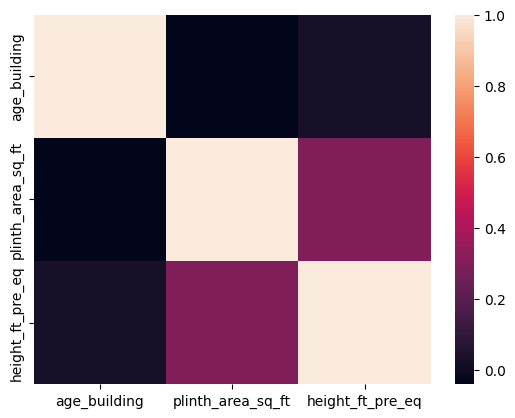

In [7]:
# check for multi-collinearity
correlation = df.select_dtypes(include="number").drop(columns="severe_damage").corr()

sns.heatmap(correlation);

## Explore

**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to add axis labels and title.

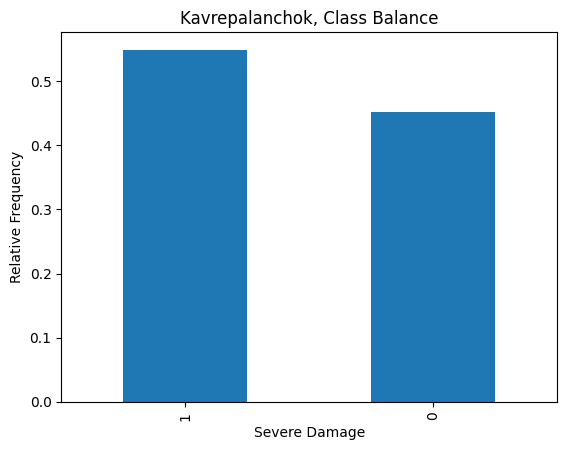

In [8]:
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Severe Damage",
    ylabel="Relative Frequency",
    title="Kavrepalanchok, Class Balance"
);

**Task 4.5.7:** Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your axes and add title.

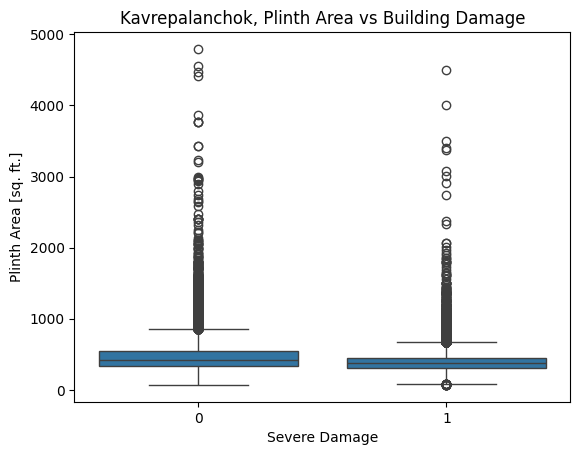

In [9]:
sns.boxplot(x = "severe_damage", y = "plinth_area_sq_ft", data = df)
plt.xlabel("Severe Damage")
plt.ylabel("Plinth Area [sq. ft.]")
plt.title("Kavrepalanchok, Plinth Area vs Building Damage");

**Task 4.5.8:** Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [10]:
roof_pivot = pd.pivot_table(df, index="roof_type", values="severe_damage", aggfunc=np.mean).sort_values(by="severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


## Split

**Task 4.5.9:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [11]:
target = "severe_damage"
X = df.drop(columns= target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


**Task 4.5.10:** Divide your dataset into training, validation, and test sets using a randomized split. Your validation set should be 20% of your data.

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48980, 11)
y_train shape: (48980,)
X_test shape: (12246, 11)
y_test shape: (12246,)


# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [13]:
acc_baseline = y.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

**Task 4.5.12:** Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [21]:
model_lr = make_pipeline(
            OneHotEncoder(use_cat_names=True),
            LogisticRegression(max_iter=4000)
            )
# fit the data into the model
model_lr.fit(X_train, y_train)

,steps,"[('onehotencoder', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


**Task 4.5.13:** Calculate training and validation accuracy score for `model_lr`. 

In [22]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", round(lr_train_acc, 2))
print("Logistic Regression, Validation Accuracy Score:", round(lr_val_acc, 2))

Logistic Regression, Training Accuracy Score: 0.65
Logistic Regression, Validation Accuracy Score: 0.65


**Task 4.5.14:** Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth.

In [23]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth= d, random_state=42)
    )
                             
    # fit the data    
    model_dt.fit(X_train, y_train)
    
    # store training and validation accuracy score
    training_acc.append(accuracy_score(y_train, model_dt.predict(X_train)))
    validation_acc.append(model_dt.score(X_val, y_val))

**Task 4.5.15:** Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your axes, add title, and include a legend. 

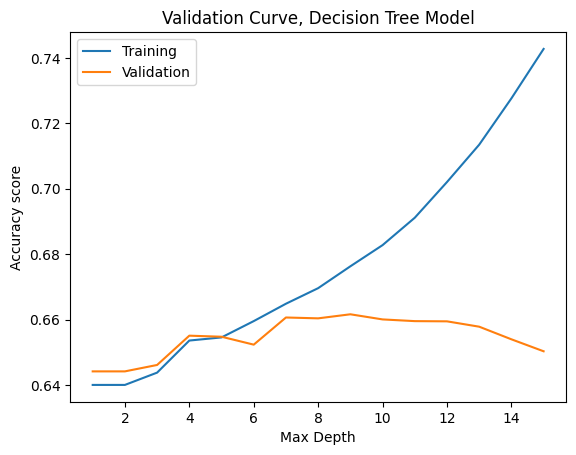

In [24]:
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend();


**Task 4.5.16:** Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [45]:
final_model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=9, random_state=42)
    )
final_model_dt.fit(X_train, y_train)

,steps,"[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,mapping,"[{'col': 'land_surface_condition', 'data_type': dtype('O'), 'mapping': Flat ...2 dtype: int64}, {'col': 'foundation_type', 'data_type': dtype('O'), 'mapping': Mud mortar-St...2 dtype: int64}, ...]"
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


## Evaluate

**Task 4.5.17:** How does your model perform on the test set? Use `final_model_dt` to generate a list of test predictions `y_test_pred`, from your test test data, and  calculate the accuracy score. 

In [46]:
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 1])

In [48]:
print("Accuracy score of the test set:", round(accuracy_score(y_test, y_test_pred), 2))

Accuracy score of the test set: 0.67


# Communicate Results

**Task 4.5.18:** What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [49]:
features = X_train.columns
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail()

plinth_area_sq_ft    0.054871
superstructure       0.080435
age_building         0.111787
height_ft_pre_eq     0.117470
roof_type            0.570326
dtype: float64

**Task 4.5.19:** Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Feature"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

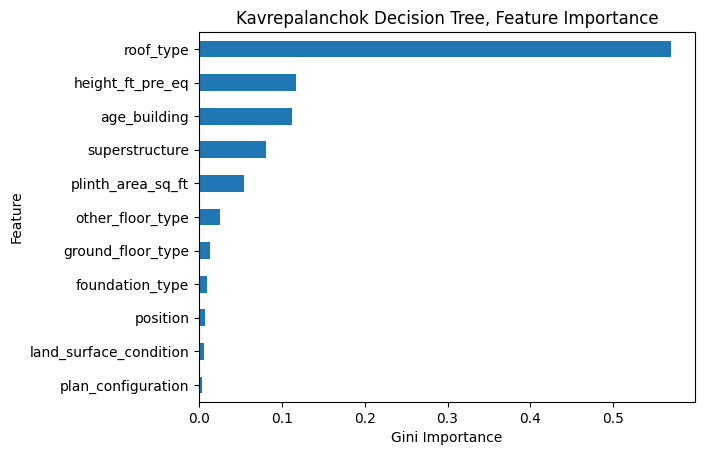

In [50]:
# Horizontal bar chart of feature importances
feat_imp.plot(kind="barh",
              xlabel="Gini Importance",
              ylabel="Feature",
              title="Kavrepalanchok Decision Tree, Feature Importance");

EDA showed `roof_type` has the strongest correlation with severe damage.
The model independently identified `roof_type` as the top predictive feature.

Bamboo/timber roofs are lightweight and flexible, making them vulnerable to collapse during seismic activity.